# Result

Here are presented the first results of the analyse of Wikipedia RFA. For more detail about our work, method, timeline and objective, see the readme on the github reprository here: https://github.com/epfl-ada/ada-2024-project-supercoolteamname2024/tree/main

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import os

# Read the data from classifications.txt file
file_path = os.path.join('data', 'classifications.txt')
data = []
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        # Match format "Username: Topic1, Topic2, ..."
        match = re.match(r'^(.*?):\s*(.*)$', line.strip())
        if match:
            user = match.group(1).strip()
            topics_str = match.group(2)
            # Split topics by commas and 'and' conjunctions, then clean spaces
            topics = [topic.strip() for topic in re.split(r',|\band\b', topics_str)]
            data.append({"user": user, "topics": topics})

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Count occurrences of each topic across all users
topic_counts = Counter(topic for topics in df["topics"] for topic in topics)

# Provided categories list
categories = [
    "Academic disciplines", "Business", "Communication", "Concepts", "Culture", "Economy", "Education", "Energy",
    "Engineering", "Entertainment", "Entities", "Food and drink", "Geography", "Government", "Health", "History",
    "Human behavior", "Humanities", "Information", "Internet", "Knowledge", "Language", "Law", "Life", "Lists", 
    "Mass media", "Mathematics", "Military", "Nature", "People", "Philosophy", "Politics", "Religion", "Science", 
    "Society", "Sports", "Technology", "Time", "Universe", "Other"
]

# Creating a DataFrame for the counts, using the provided category order
topic_counts_df = pd.DataFrame({"Topic": categories})
topic_counts_df["Count"] = topic_counts_df["Topic"].map(topic_counts).fillna(0).astype(int)



# Categories distribution

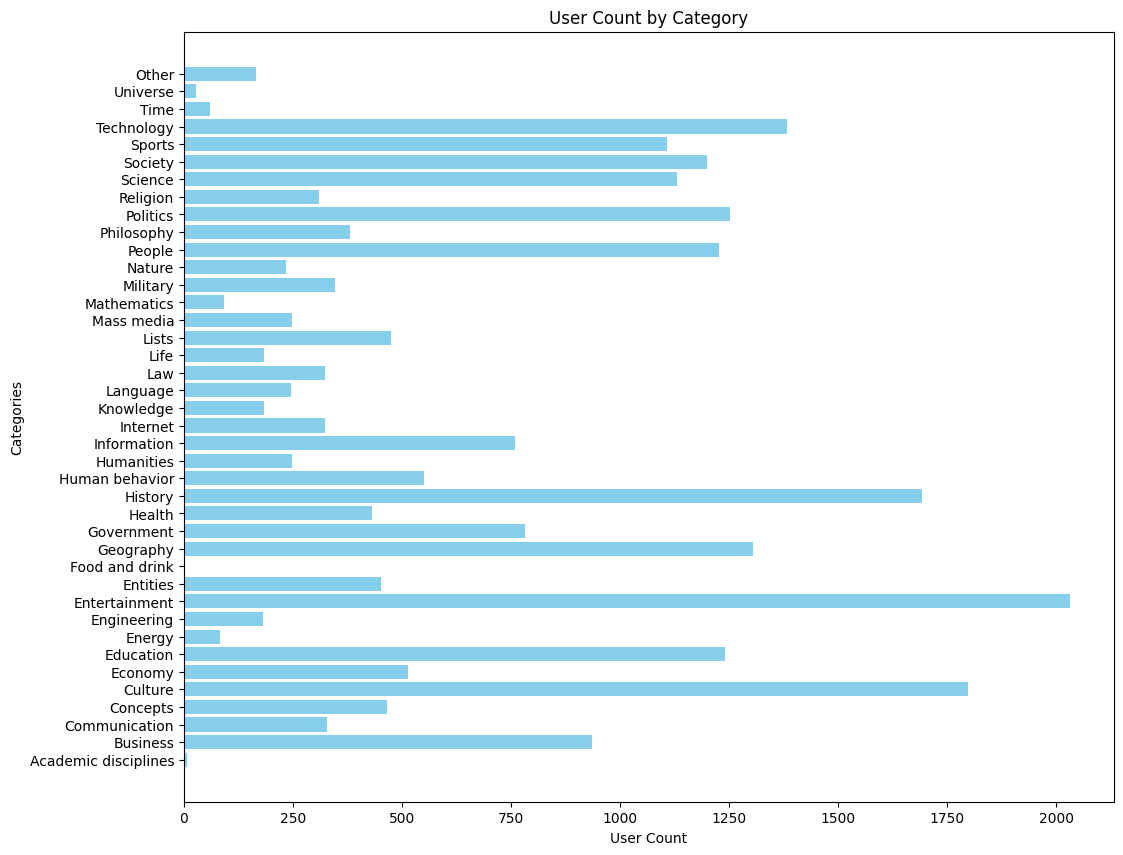

In [45]:

# Plotting the topics with their counts in the order provided
plt.figure(figsize=(12, 10))
plt.barh(topic_counts_df["Topic"], topic_counts_df["Count"], color="skyblue")
plt.xlabel("User Count")
plt.ylabel("Categories")
plt.title("User Count by Category")
plt.show()


The bar chart illustrates a diverse distribution of user interests across various categories, with each user potentially belonging to up to 4 different categories. The varying sizes of these categories may be attributed to the breadth of the topics themselves, as some categories, like Technology, may encompass broader subtopics such as Internet. Notably, certain categories have significantly higher user counts, while others are relatively small. To ensure statistical significance in subsequent analyses, we plan to exclude the smallest categories where the sample size may be insufficient for robust conclusions

# Participation rate same/different group

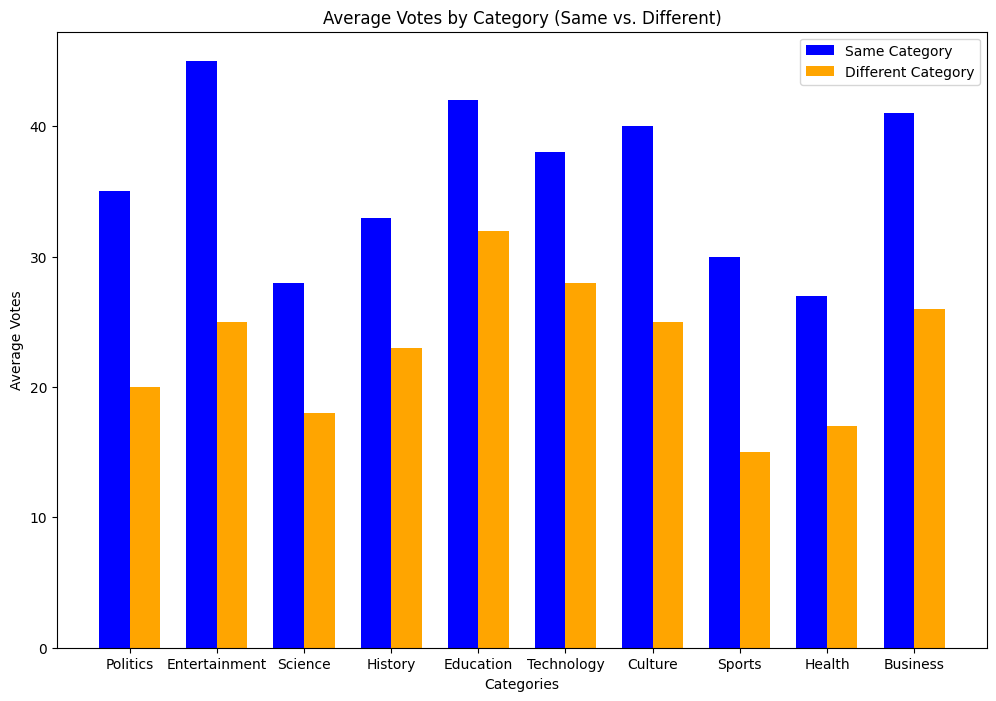

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with actual data: The 10 largest categories
categories = ['Politics', 'Entertainment', 'Science', 'History', 'Education', 
              'Technology', 'Culture', 'Sports', 'Health', 'Business']

# Replace with actual computed means for each category
# Mean votes for "Same Category" and "Different Category" for the 10 largest categories
mean_votes_same_category = [35, 45, 28, 33, 42, 38, 40, 30, 27, 41]  # Placeholder data
mean_votes_diff_category = [20, 25, 18, 23, 32, 28, 25, 15, 17, 26]  # Placeholder data

# Plotting "Same Category" and "Different Category" side by side for each category
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(categories))

# Bars for Same Category
ax.bar(index, mean_votes_same_category, bar_width, label='Same Category', color='blue')

# Bars for Different Category
ax.bar(index + bar_width, mean_votes_diff_category, bar_width, label='Different Category', color='orange')

# Adding labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Average Votes')
ax.set_title('Average Votes by Category (Same vs. Different)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

plt.show()


Analyzing the top 10 largest categories, we observe that users are more inclined to participate in votes related to topics that align with their own interests. This can be explained by the fact that individuals are likely to feel more knowledgeable or proficient in certain areas, making them more comfortable expressing their opinions or casting votes. This trend persists, even in the mid-sized categories ranked 10 to 20, suggesting a consistent preference for engaging with familiar topics across the user base.


# Tolerance across same/different categories

## Code


In [47]:
import re
import pandas as pd
from collections import Counter
from scipy.stats import chi2_contingency
from IPython.display import display  # For rendering in Jupyter Notebook
from IPython.display import HTML


# Step 1: Parse classifications.txt to create a category mapping for each user
category_mapping = {}
with open('data/classifications.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("Here are the classifications"):  # Skip empty or irrelevant lines
            continue
        
        # Extract the username and categories
        match = re.match(r'^(.+?):\s(.*)$', line)  # Fixed regex to correctly capture username and categories
        if match:
            user, categories_str = match.groups()
            categories = [cat.strip() for cat in categories_str.split(",") if cat.strip()]  # Avoid empty categories
            category_mapping[user.strip()] = categories

# Flatten the category list to count occurrences and get the top 20 categories
all_categories = [cat for categories in category_mapping.values() for cat in categories]
top_20_categories = [cat for cat, _ in Counter(all_categories).most_common(20)]


# Step 2: Parse wiki-RfA.txt to extract votes and determine "Same Category" or "Different Category"
data = {
    "SRC": [],
    "TGT": [],
    "VOT": [],
    "Category_Same": [],  # New column to track if category matches
    "SRC_Category": [],  # Store source category
    "TGT_Category": []   # Store target category (added for clarity)
}

with open('data/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    record = {}
    for line in file:
        line = line.strip()
        
        # Check if line is empty (end of a record)
        if not line:
            # Save the current record if it has data and reset
            if record:
                src_cat = set(category_mapping.get(record.get("SRC", ""), []))
                tgt_cat = set(category_mapping.get(record.get("TGT", ""), []))
                
                # Skip if either source or target has no categories assigned
                if not src_cat or not tgt_cat:
                    record = {}
                    continue
                
                # Determine if categories match
                record["Category_Same"] = int(bool(src_cat & tgt_cat))  # 1 if any category matches, else 0
                record["SRC_Category"] = list(src_cat & set(top_20_categories))  # Intersection with top categories
                record["TGT_Category"] = list(tgt_cat & set(top_20_categories))  # Intersection with target categories
                
                # Append record to data dictionary
                data["SRC"].append(record.get("SRC", ""))
                data["TGT"].append(record.get("TGT", ""))
                data["VOT"].append(int(record.get("VOT", 0)))
                data["Category_Same"].append(record["Category_Same"])
                data["SRC_Category"].append(record["SRC_Category"][0] if record["SRC_Category"] else None)
                data["TGT_Category"].append(record["TGT_Category"][0] if record["TGT_Category"] else None)
                record = {}
            continue
        
        # Match each line with its prefix and store it in the record dictionary
        match = re.match(r"^(SRC|TGT|VOT):(.*)$", line)
        if match:
            key, value = match.groups()
            record[key] = value.strip()

    # Add the last record if any data is left
    if record:
        src_cat = set(category_mapping.get(record.get("SRC", ""), []))
        tgt_cat = set(category_mapping.get(record.get("TGT", ""), []))
        
        # Skip if either source or target has no categories assigned
        if not src_cat or not tgt_cat:
            record = {}
        else:
            record["Category_Same"] = int(bool(src_cat & tgt_cat))
            record["SRC_Category"] = list(src_cat & set(top_20_categories))
            record["TGT_Category"] = list(tgt_cat & set(top_20_categories))

            data["SRC"].append(record.get("SRC", ""))
            data["TGT"].append(record.get("TGT", ""))
            data["VOT"].append(int(record.get("VOT", 0)))
            data["Category_Same"].append(record["Category_Same"])
            data["SRC_Category"].append(record["SRC_Category"][0] if record["SRC_Category"] else None)
            data["TGT_Category"].append(record["TGT_Category"][0] if record["TGT_Category"] else None)

# Convert data into a DataFrame
df = pd.DataFrame(data)



# Step 3: Analyze tolerance rates for each of the 20 biggest categories
results = []
for category in top_20_categories:
    # Filter votes by users in the current category
    category_votes = df[df['SRC_Category'] == category]
    
    # Calculate positive and negative vote counts within and outside the category
    same_category_votes = category_votes[category_votes['Category_Same'] == 1]
    diff_category_votes = category_votes[category_votes['Category_Same'] == 0]
    
    same_pos_count = (same_category_votes['VOT'] == 1).sum()
    same_neg_count = (same_category_votes['VOT'] == -1).sum()
    diff_pos_count = (diff_category_votes['VOT'] == 1).sum()
    diff_neg_count = (diff_category_votes['VOT'] == -1).sum()
    
    # Check if we have non-zero counts before performing the Chi-square test
    if same_pos_count > 0 and same_neg_count > 0 and diff_pos_count > 0 and diff_neg_count > 0:
        contingency_table = [[same_pos_count, same_neg_count], [diff_pos_count, diff_neg_count]]
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
    else:
        chi2, p_value = None, None  # If any count is zero, skip the Chi-square test
    
    # Append results for this category
    results.append({
        "Category": category,
        "Same_Pos": same_pos_count,
        "Same_Neg": same_neg_count,
        "Diff_Pos": diff_pos_count,
        "Diff_Neg": diff_neg_count,
        "Chi-Square Distance": chi2 if chi2 is not None else "N/A",
        "p-value": p_value if p_value is not None else "N/A"
    })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Convert the results DataFrame into a nicely formatted HTML table
results_html = results_df.to_html(index=False, columns=["Category", "Same_Pos", "Same_Neg",  "Diff_Pos", "Diff_Neg", "Chi-Square Distance", "p-value"], justify="center", border=1)

# Select and rename columns for clarity
results_table = results_df[["Category", "Same_Pos", "Same_Neg", "Diff_Pos", "Diff_Neg", "p-value"]]
results_table.columns = ["Category", "Same Category Positive Votes", "Same Category Negative Votes", "Different Category Positive Votes", "Different Category Negative Votes", "p-value"]

# Display the table as a styled HTML table
styled_table = results_table.style.set_table_styles(
    [
        {'selector': 'th', 'props': [('background-color', '#f7f7f7'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
    ]
).set_caption("Tolerance Analysis Results")




In [48]:
from IPython.display import display

# Select three categories to analyze
categories_to_analyze = ["Entertainment", "Geography", "Business"]

# Filter the results_table for the selected categories
selected_categories = results_table[results_table["Category"].isin(categories_to_analyze)]

# Compute rates and prepare analysis
rate_analysis = []

for _, row in selected_categories.iterrows():
    category = row["Category"]
    same_pos = row["Same Category Positive Votes"]
    diff_pos = row["Different Category Positive Votes"]
    same_neg = row["Same Category Negative Votes"]
    diff_neg = row["Different Category Negative Votes"]
    
    # Calculate totals
    total_same = same_pos + same_neg
    total_diff = diff_pos + diff_neg
    
    # Calculate rates
    same_pos_rate = same_pos / total_same if total_same > 0 else 0
    diff_pos_rate = diff_pos / total_diff if total_diff > 0 else 0
    
    # Append to analysis
    rate_analysis.append({
        "Category": category,
        "Positive Rate Within Same (%)": same_pos_rate * 100,
        "Positive Rate Within Different (%)": diff_pos_rate * 100
    })

# Convert to DataFrame for display
selected_rates_df = pd.DataFrame(rate_analysis)



## Table


In [49]:
# Render the styled table
display(styled_table)

,Category,Same Category Positive Votes,Same Category Negative Votes,Different Category Positive Votes,Different Category Negative Votes,p-value
0,Entertainment,939,273,1477,330,0.004727
1,Culture,6387,1244,6413,1371,0.031787
2,History,1378,347,1338,378,0.182412
3,Technology,4233,944,5145,1085,0.265317
4,Geography,274,96,489,117,0.018456
5,Politics,696,140,970,194,1.000000
6,Education,986,195,1170,228,0.932305
7,People,1962,363,2301,484,0.098395
8,Society,54,10,147,18,0.451576
9,Science,374,87,845,284,0.008733


In [50]:
# Display computed rates
print("Computed Rates for Selected Categories:")
display(selected_rates_df.style.set_caption("Positive Rate Analysis for Selected Categories"))

# Brief analysis
print("\nAnalysis:")
print("We can see that the rate of positiv vote is greater when the target of the vote is from a \ndifferent group,  hence we could think that they are stricter and more exigent with people \nfrom their category.")
print("Among certain group, p-values indicate significantly different level of tolerance whether \nthey belong to the same group or not is. ")

Computed Rates for Selected Categories:


,Category,Positive Rate Within Same (%),Positive Rate Within Different (%)
0,Entertainment,77.475248,81.737687
1,Geography,74.054054,80.693069
2,Business,80.524079,83.140054



Analysis:
We can see that the rate of positiv vote is greater when the target of the vote is from a 
different group,  hence we could think that they are stricter and more exigent with people 
from their category.
Among certain group, p-values indicate significantly different level of tolerance whether 
they belong to the same group or not is. 


## Analysis